In [29]:
'''Implementation of the ABC-SMC algorithm in https://www.pnas.org/doi/10.1073/pnas.0607208104'''

'Implementation of the ABC-SMC algorithm in https://www.pnas.org/doi/10.1073/pnas.0607208104'

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as mvn

In [31]:
'''Tau leaping model so we have some stochasticity. '''

days = 100
delta_t = 0.1 
rng = np.random.default_rng(0)

def model(theta,rng,*,days,delta_t,log = False): 
    beta,gamma = theta
    if log:
        beta = np.exp(beta)
        gamma = np.exp(gamma)

    S = np.zeros(days * int(1/delta_t))
    I = np.zeros(days * int(1/delta_t))
    R = np.zeros(days * int(1/delta_t))

    #Initial condition
    S[0] = 500
    I[0] = 5
    R[0] = 0

    N = S[0] + I[0] + R[0]

    for t in range(1,int(1/delta_t) * days): 

        #Rate equations
        dN_SI = rng.poisson(max(beta * (S[t-1] * I[t-1]/N) * delta_t,0.))
        dN_IR = rng.poisson(max(I[t-1] * gamma * delta_t,0.))

        S[t] = S[t-1] - dN_SI
        I[t] = I[t-1] + dN_SI - dN_IR
        R[t] = R[t-1] + dN_IR

    return (S,I,R) 

theta = (0.3,0.1) #Real parameters
_,data_full,_ = model(theta,rng,days = days,delta_t = delta_t)


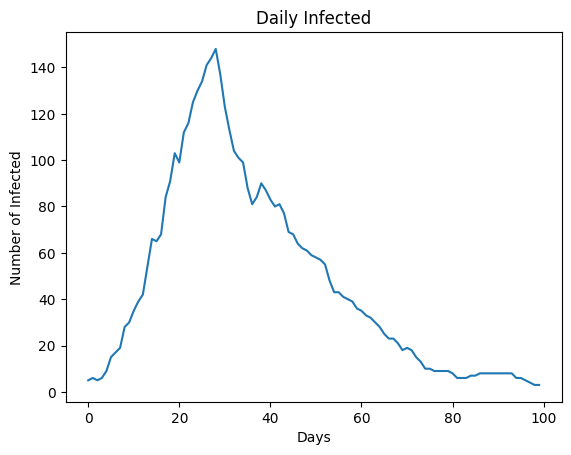

In [32]:
#Extract the data daily
data_real = data_full[::int(1/delta_t)]

plt.title('Daily Infected')
plt.xlabel('Days')
plt.ylabel('Number of Infected')
plt.plot(np.arange(0,days,1),data_real)

In [33]:
#Tempering parameters 
eps = np.flip(np.linspace(0,1000,20))

num_particles = 5_000

#Choosing the prior is quite important here
#We choose a normal distribution, remember we are in log-space
#normal(ln(1/2),ln(1/2),I))
prior = mvn(np.array([-np.log(2),-np.log(2)]),np.eye(2),seed = rng)

#Special case t = 0, draw the particles uniformly
particles = prior.rvs(size = (num_particles,))
weights = np.full((num_particles,),1/num_particles)

for iteration in range(1,len(eps)): 

    #Mutation/M-Kernel step

    particle_props = particles + 0.01 * rng.multivariate_normal(np.zeros(2),np.eye(2),size = (num_particles,))

    data_sets = np.zeros((num_particles,days))
    for index,p in enumerate(particles): 
        _,data_p,_ = model(p,rng,days = days,delta_t = delta_t,log = True)
        data_p = data_p[::int(1/delta_t)]

        distance = np.sqrt(np.sum((data_real - data_p)**2))

        #Weights
        if(distance < eps[iteration]): 
            weights[index] = prior.pdf(particles[index])/prior.pdf(particle_props[index])
            particles[index] = particle_props[index]

        #Store the data on last iteration, doing this after the perturbation is probably not correct
        if(iteration == (len(eps)-1)): 
            data_sets[index,:] = data_p

    #Normalize weights
    weights /= np.sum(weights)

    ESS = 1/np.sum(weights**2)
    print(f"ESS {ESS} on iteration {iteration}.")

    #Resampling
    indices = rng.choice(np.arange(num_particles),size = (num_particles,), replace = True, p = weights)
    particles = particles[indices,:]
    weights = np.full((num_particles,),1/num_particles)
    


ESS 4834.16504217639 on iteration 1.
ESS 4915.164397645035 on iteration 2.
ESS 4904.184070496941 on iteration 3.
ESS 4866.200498529239 on iteration 4.
ESS 4838.2347529762665 on iteration 5.
ESS 4748.286264593986 on iteration 6.
ESS 4399.552532664326 on iteration 7.
ESS 954.4970570797012 on iteration 8.
ESS 2903.4070631254613 on iteration 9.
ESS 3108.2119553554894 on iteration 10.
ESS 3050.192090970073 on iteration 11.
ESS 2986.1590652182895 on iteration 12.
ESS 2929.1675585297808 on iteration 13.
ESS 2883.1760396890086 on iteration 14.
ESS 2214.5829592379755 on iteration 15.
ESS 1098.2473214288264 on iteration 16.
ESS 216.8584681268182 on iteration 17.
ESS 5000.000000000002 on iteration 18.
ESS 5000.000000000002 on iteration 19.


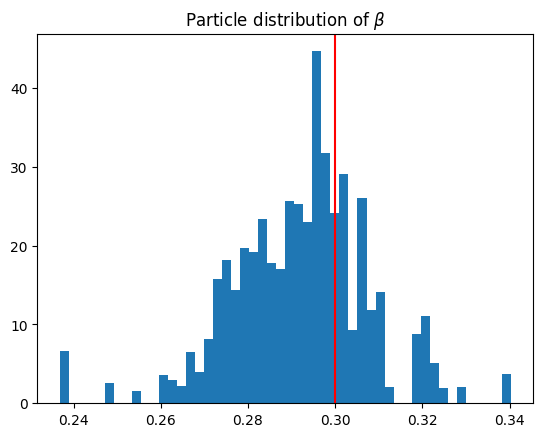

In [37]:
plt.title('Particle distribution of $\\beta$')
plt.hist(np.exp(particles[:,0]),bins = 50,density = True)
plt.axvline(theta[0],color = 'red')

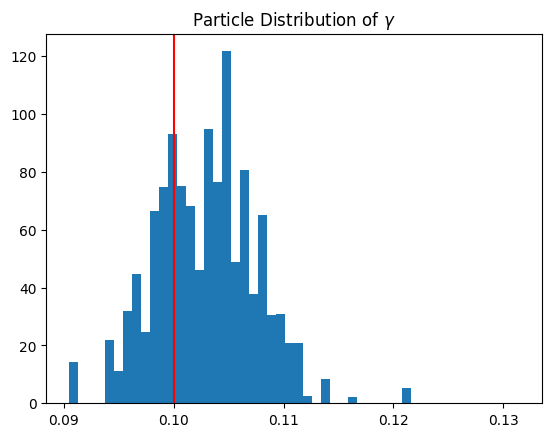

In [38]:
plt.title('Particle Distribution of $\\gamma$')
plt.hist(np.exp(particles[:,1]),bins = 50,density = True)
plt.axvline(theta[1],color = 'red')

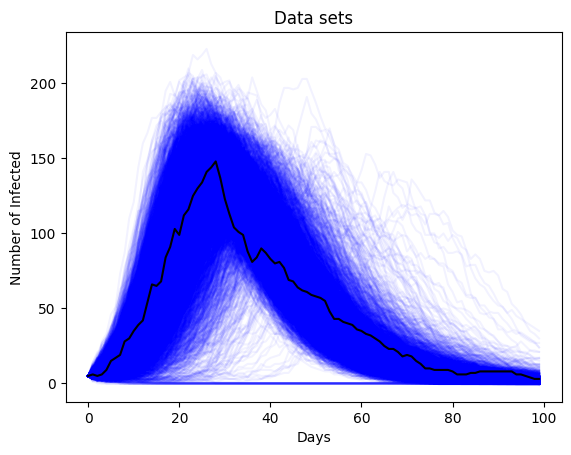

In [39]:
plt.title('Data sets')
plt.xlabel('Days')
plt.ylabel('Number of Infected')
plt.plot(np.arange(0,days,1),data_sets.T,color = 'blue',alpha = 0.05)
plt.plot(np.arange(0,days,1),data_real,color = 'black')
plt.show()